0.0
0.0005398219218477607
8641
('thresh', 'npix', 'tnpix', 'xmin', 'xmax', 'ymin', 'ymax', 'x', 'y', 'x2', 'y2', 'xy', 'errx2', 'erry2', 'errxy', 'a', 'b', 'theta', 'cxx', 'cyy', 'cxy', 'cflux', 'flux', 'cpeak', 'peak', 'xcpeak', 'ycpeak', 'xpeak', 'ypeak', 'flag')
object 0: flux = 0.031282 +/- 0.176890
object 1: flux = 0.031018 +/- 0.176142
object 2: flux = -0.024388 +/- 0.002883
object 3: flux = 0.001947 +/- 0.044219
object 4: flux = 0.012457 +/- 0.111649
object 5: flux = -0.011228 +/- 0.002875
object 6: flux = 0.029368 +/- 0.171394
object 7: flux = -0.009126 +/- 0.002875
object 8: flux = 0.048023 +/- 0.219161
object 9: flux = 0.027840 +/- 0.166877


C:\Users\Savan\AppData\Local\Temp\ipykernel_10012\1783109238.py:76: RuntimeWarning: invalid value encountered in log10
  m_flux= -2.5*np.log10(flux) #since the numbers are large, logarithmic scale represents better (also used in lecture)


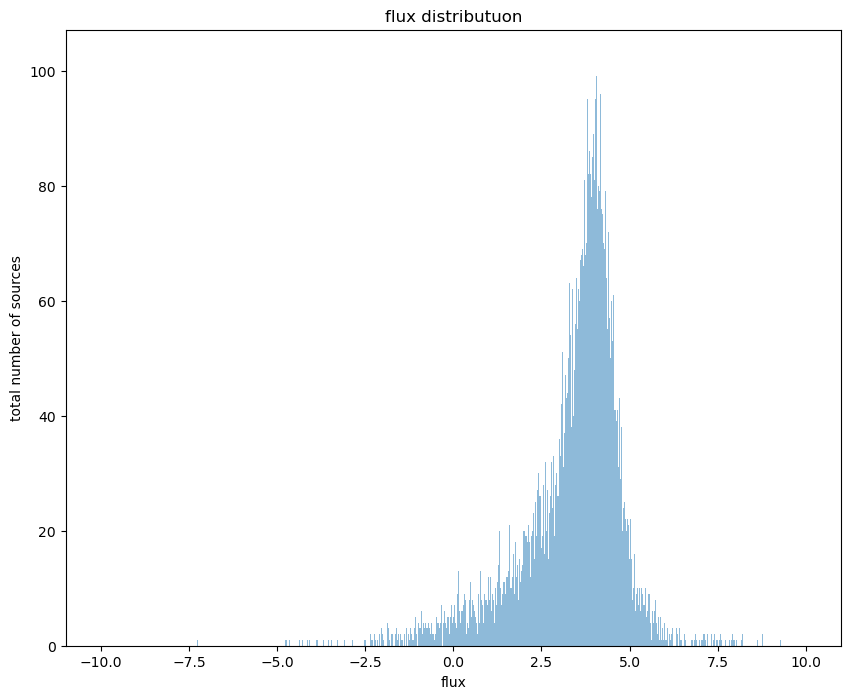

mean: 0.3618090327919336, median: 0.030954822942148894, standard deviation: 9.242994204690572
the largest outlier in the distribution has a flux of 807.2972835731507 and is at index 2067.
this outlier is 87.30238888723534 standard deviations away from the mean.
in the image, this outlier is found at position: (x, y)= (1914.2549094883857, 1134.3164850742164)


In [39]:
import numpy as np
import sep

# additional setup for reading the test image and displaying plots
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rcParams

%matplotlib inline

rcParams['figure.figsize'] = [10., 8.]

# read image into standard 2-d numpy array
with fits.open("hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits") as hdul:
    data = hdul[0].data.astype(np.float64)

# show the image
m, s = np.mean(data), np.std(data)
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar()
plt.savefig("original_image.png")
plt.close()

# measure a spatially varying background on the image
bkg = sep.Background(data)
bkg = sep.Background(data, mask=None, bw=64, bh=64, fw=3, fh=3)
# get a "global" mean and noise of the image background:
print(bkg.globalback)
print(bkg.globalrms)
# evaluate background as 2-d array, same size as original image
bkg_image = bkg.back()
# show the background
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar()
plt.savefig("background_image.png")
plt.close()

# subtract the background
data_sub = data - bkg
objects = sep.extract(data_sub, 1.5, err=bkg.globalrms)
# number of sources is the length of objects
sources = len(objects)
# how many objects were detected
print(len(objects))

from matplotlib.patches import Ellipse
# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation="nearest", cmap="gray",
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse on the image around each object 
for i in range(len(objects)):
    e = Ellipse(xy=(objects["x"][i], objects["y"][i]),
                width=6*objects["a"][i],
                height=6*objects["b"][i],
                angle=objects["theta"][i] * 180. / np.pi)
    e.set_facecolor("none")
    e.set_edgecolor("red")
    ax.add_artist(e)
plt.savefig("background_subtracted_image.png")
plt.close()

# available fields
print(objects.dtype.names)

flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'],
                                     3.0, err=bkg.globalrms, gain=1.0)
# show the first 10 objects results:
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

# Plotting histogram for fluxes for each object
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'], 3.0, err=bkg.globalrms, gain=1.0)
m_flux= -2.5*np.log10(flux) #since the numbers are large, logarithmic scale represents better (also used in lecture)
plt.hist(m_flux, range=[-10, 10], bins= 1000, alpha=0.5) 
plt.title("flux distributuon")
plt.xlabel("flux")
plt.ylabel("total number of sources")
plt.savefig("histogram.png")
plt.show()

#Question 7: mean, median, max, and stdev for flux
f_mean= np.mean(flux)
f_median= np.median(flux)
f_stdev= np.std(flux)
f_max=np.max(flux)
outlier_place=np.argmax(flux) #finds the index of the outlier object with the greatest flux
num_stdev= ((f_max-f_mean)/f_stdev) #counts how many standard deviations the outlier is from the mean

print(f"mean: {f_mean}, median: {f_median}, standard deviation: {f_stdev}")

#using outlier position to print the outlier and find its location in the image
large_x, large_y = objects["x"][outlier_place], objects["y"][outlier_place]
print(f"the largest outlier in the distribution has a flux of {f_max} and is at index {outlier_place}.")
print(f"this outlier is {num_stdev} standard deviations away from the mean.")
print(f"in the image, this outlier is found at position: (x, y)= ({large_x}, {large_y})")

